# Hate Speech Classification

In [36]:
pwd

'/content'

### Import the necessary libraries

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
### Read the data

In [38]:
imbalance_data = pd.read_csv("/content/imbalanced_data.csv")

In [39]:
imbalance_data.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


---
### EDA

<Axes: xlabel='label', ylabel='count'>

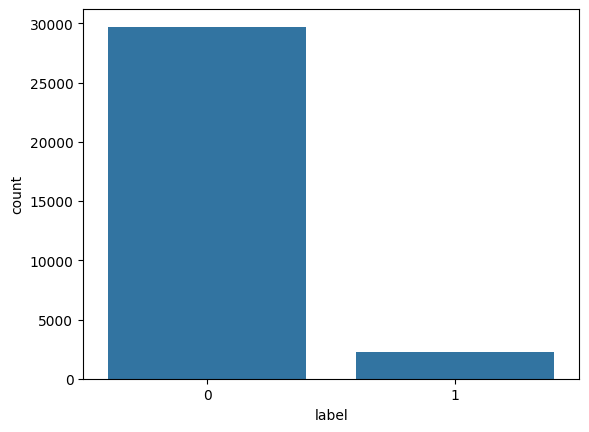

In [40]:
sns.countplot(x='label',data =imbalance_data)

From the above plot we can see that classes are imbalanced, we will fix it later.

In [41]:
# Checking the shape of the data
imbalance_data.shape

(31962, 3)

In [42]:
# Cheking if null values are present in the dataset or not.
imbalance_data.isnull().sum()

,0
id,0
label,0
tweet,0


In [43]:
# Let's drop the 'id' column as it is not required.
imbalance_data.drop('id',axis=1, inplace =True)

In [44]:
# Let's load another dataset similar to our dataset, since we want to fix the imbalance data.
raw_data = pd.read_csv("/content/raw_data.csv")

In [45]:
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [46]:
raw_data.shape

(24783, 7)

In [47]:
raw_data.isnull().sum()

,0
Unnamed: 0,0
count,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


In [48]:
# Let's drop the columns which are not required for us.
raw_data.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace =True)

In [49]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [50]:
# Let's check for the unique values in the dataset
raw_data['class'].unique()

array([2, 1, 0])

<Axes: xlabel='class', ylabel='count'>

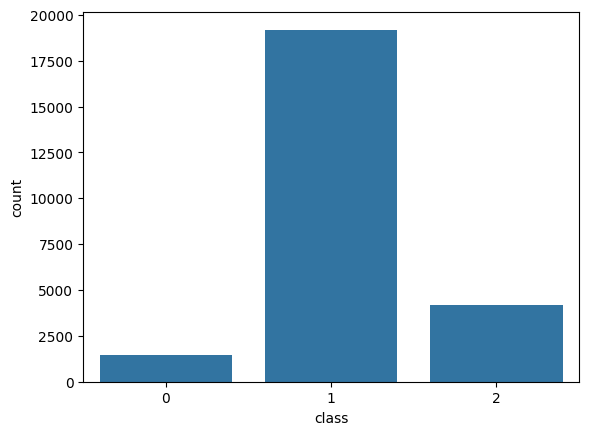

In [51]:
# Plotting the countplot for our new dataset
sns.countplot(x='class',data =raw_data)

- class 0: hate, class 1: abusive, and class 2: no hate.
- Let's copy the valus of the class 1 into class 0.

In [52]:
raw_data[raw_data['class']==0]['class']=1

/tmp/ipython-input-3600235578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[raw_data['class']==0]['class']=1


In [53]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [54]:
raw_data['class'].unique()

array([2, 1, 0])

In [55]:
# Let's check the values in the class 0
raw_data[raw_data['class']==0]

,class,tweet
85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer"" gaywad"
89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a beaner smh you can tell hes a mexican"
110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, blacklisted hoe"" Holding out for #TehGodClan anyway http://t.co/xUCcwoetmn"
184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPLE https://t.co/RNvD2nLCDR"" This is why there's black people and niggers"
202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http://t.co/RGJa7CfoiT""\n\nLmfao"
204,0,"""@NotoriousBM95: @_WhitePonyJr_ Ariza is a snake and a coward"" but at least he isn't a cripple like your hero Roach lmaoo"
219,0,"""@RTNBA: Drakes new shoes that will be released by Nike/Jordan.... Yes, there's glitter on the shoes http://t.co/QCtPLxHEXM"" ....dudes a fag"
260,0,"""@TheoMaxximus: #GerrysHalloweenParty http://t.co/3ycrSrnjHc"" Halloween was yesterday stupid nigger"
312,0,"""@ashlingwilde: @ItsNotAdam is bored supposed to be cute, you faggot?"" Sometimes"
315,0,"""@bigbootybishopp: @white_thunduh lassen cc , the coach wants me"" i feel it youll get more my nig no doubt"


In [56]:
# replace the value of 0 to 1
raw_data["class"].replace({0:1},inplace=True)

/tmp/ipython-input-376421553.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_data["class"].replace({0:1},inplace=True)


In [57]:
raw_data["class"].unique()

array([2, 1])

<Axes: xlabel='class', ylabel='count'>

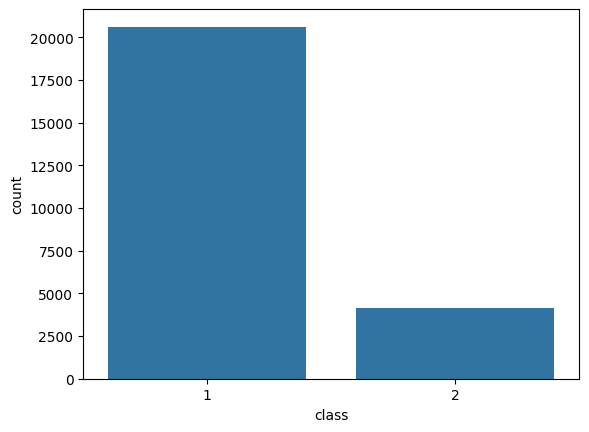

In [58]:
sns.countplot(x="class",data= raw_data)

In [59]:
# Let's replace the value of 2 to 0.
raw_data["class"].replace({2:0}, inplace = True)

/tmp/ipython-input-385002427.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_data["class"].replace({2:0}, inplace = True)


<Axes: xlabel='class', ylabel='count'>

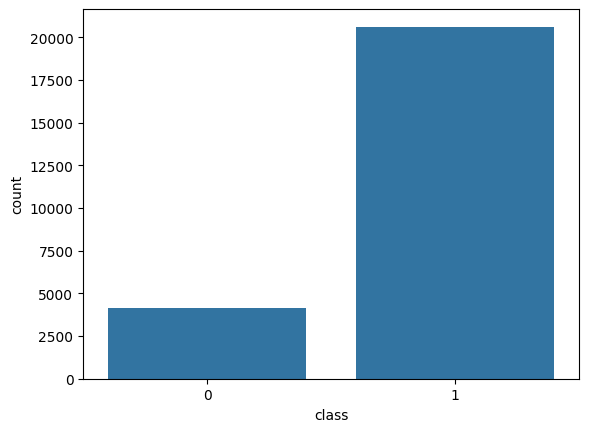

In [60]:
sns.countplot(x='class',data=raw_data)

In [61]:
# Let's change the name of the 'class' to label
raw_data.rename(columns={'class':'label'},inplace =True)

In [62]:
raw_data.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [63]:
raw_data.iloc[0]['tweet']

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [64]:
# Let's concatinate both the data into a single data frame.
frame = [imbalance_data, raw_data]
df = pd.concat(frame)

In [65]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


<Axes: xlabel='label', ylabel='count'>

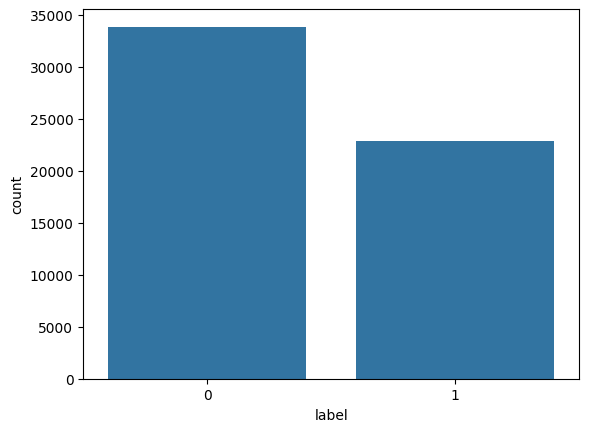

In [66]:
sns.countplot(x='label',data=df)

Now we can see that the problem of imbalace data has been solved.

In [67]:
df.shape

(56745, 2)

In [68]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [69]:
def data_cleaning(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove stopwords
    words = [word for word in text.split() if word not in stopword]

    # Apply stemming
    words = [stemmer.stem(word) for word in words]

    # Join back into string
    return " ".join(words)


In [70]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [71]:
df["tweet"][3]

,tweet
3,model love u take u time urð± ðððð ð¦ð¦ð¦
3,rt cganderson vivabas look like tranni


In [72]:
df.head(10)

,label,tweet
0,0,user father dysfunct selfish drag kid dysfunct run
1,0,user user thank lyft credit cant use caus dont offer wheelchair van pdx disapoint getthank
2,0,bihday majesti
3,0,model love u take u time urð± ðððð ð¦ð¦ð¦
4,0,factsguid societi motiv
5,0,huge fan fare big talk leav chao pay disput get allshowandnogo
6,0,user camp tomorrow user user user user user user user dannyâ¦
7,0,next school year year examsð¯ cant think ð­ school exam hate imagin actorslif revolutionschool girl
8,0,love land allin cav champion cleveland clevelandcavali â¦
9,0,user user welcom im


In [73]:
x = df['tweet']
y = df['label']

In [74]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

42558 42558
14187 14187


In [75]:
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [76]:
len(x_test)

14187

In [77]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [78]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [79]:
stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [80]:
# starting model training
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs = 5,
                   validation_split=0.2,callbacks=[stop,checkpoint])

Epoch 1/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.8038 - loss: 0.4151

266/266 ━━━━━━━━━━━━━━━━━━━━ 252s 925ms/step - accuracy: 0.8041 - loss: 0.4146 - val_accuracy: 0.9402 - val_loss: 0.1710
Epoch 2/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9443 - loss: 0.1560

266/266 ━━━━━━━━━━━━━━━━━━━━ 269s 951ms/step - accuracy: 0.9443 - loss: 0.1560 - val_accuracy: 0.9441 - val_loss: 0.1557
Epoch 3/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9518 - loss: 0.1434

266/266 ━━━━━━━━━━━━━━━━━━━━ 257s 935ms/step - accuracy: 0.9518 - loss: 0.1434 - val_accuracy: 0.9463 - val_loss: 0.1513
Epoch 4/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 263s 938ms/step - accuracy: 0.9623 - loss: 0.1156 - val_accuracy: 0.9462 - val_loss: 0.1569
Epoch 5/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 264s 944ms/step - accuracy: 0.9676 - loss: 0.1023 - val_accuracy: 0.9461 - val_loss: 0.1569


In [81]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [82]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

444/444 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.9433 - loss: 0.1697


In [83]:
lstm_prediction = model.predict(test_sequences_matrix)

444/444 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step


In [84]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.4:
        res.append(0)
    else:
        res.append(1)


In [85]:
print(confusion_matrix(y_test,res))

[[8248  205]
 [ 593 5141]]


In [86]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
# Let's save the mdoel.
model.save("model.h5")

In [88]:
import keras

In [89]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [91]:
# Let's test our model on custom data.
test = "You are so ugly and disgusting"
def data_cleaning(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove stopwords
    words = [word for word in text.split() if word not in stopword]

    # Apply stemming
    words = [stemmer.stem(word) for word in words]

    # Join back into string
    return " ".join(words)

test=[data_cleaning(test)]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = load_model.predict(padded)
prediction=float(pred[0][0])
print("pred", prediction)
if prediction<0.4:
    print("no hate")
else:
    print("hate and abusive")


['ugli disgust']
[[255, 996]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
pred 0.46537071466445923
hate and abusive
